**Library**

---



1.   https://github.com/zademn/netsci-labs
2.   https://karateclub.readthedocs.io/en/latest/
3.   https://praw.readthedocs.io/en/stable/



In [ ]:
pip install networkx==2.5.1

In [ ]:
pip install matplotlib==3.4.3

PRAW stands for "Python Reddit API Wrapper." It is a Python library that provides a convenient way to interact with the Reddit API. PRAW allows developers to easily access and interact with Reddit's features, such as reading and submitting posts, accessing user information, and retrieving comments. Let's install PRAW:

In [ ]:
pip install praw

Next, let’s use the Karate Club dataset to illustrate classification algorithms. 
The Karate Club dataset is a famous social network dataset that represents the social interactions among members of a university karate club. It is commonly used in the field of network analysis and community detection.

In [ ]:
pip install karateclub

In [ ]:
import praw
import networkx as nx
from karateclub import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set up Reddit API credentials
reddit = praw.Reddit(
    client_id='aaqo7P5fUXCJ1vvEHr_zXQ',
    client_secret='ATuvKXql-pzU6-7mqb-lqfuEs--J8w',
    user_agent='Robert, Andrada, IC project 1.0'
)

# Define the subreddit and create the graph
subreddit_name = 'Romania'
graph = nx.Graph()

subreddit = reddit.subreddit(subreddit_name)
for submission in subreddit.hot(limit=5):  # Adjust the limit as per your needs
    # Add submission as a node in the graph
    graph.add_node(submission.id, text=submission.title, type='submission')
    # Connect submission nodes with author nodes if author information is available
    if submission.author is not None:
        graph.add_edge(submission.id, submission.author.name, type='author')
    # Collect comments and connect them to their parent submissions or authors
    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        graph.add_node(comment.id, text=comment.body, type='comment')
        # Connect comments with author nodes if author information is available
        if comment.author is not None:
            graph.add_edge(comment.id, comment.author.name, type='author')
        if comment.parent_id.startswith('t3_'):  # Parent is a submission
            graph.add_edge(comment.id, comment.parent_id, type='comment_to_submission')
        else:  # Parent is another comment
            graph.add_edge(comment.id, comment.parent_id[3:], type='comment_to_comment')

#graph = load('graph_cache.joblib') # can use this for cached graphs

# Create a new graph with relabeled nodes
relabeled_graph = nx.convert_node_labels_to_integers(graph, first_label=0)

# Create a Node2Vec model
model = Node2Vec(dimensions=128)

# Fit the model to the relabeled graph
model.fit(relabeled_graph)

# Get the computed node embeddings
node_embeddings = model.get_embedding()

In [ ]:
# Create a function to create a graph from a post URL
def create_graph_from_post(url):
    graph = nx.Graph()
    submission = reddit.submission(url=url)
    # Add submission as a node in the graph
    graph.add_node(submission.id, text=submission.title, type='submission')
    # Connect submission nodes with author nodes if author information is available
    if submission.author is not None:
        graph.add_edge(submission.id, submission.author.name, type='author')
    # Collect comments and connect them to their parent submissions or authors
    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        graph.add_node(comment.id, text=comment.body, type='comment')
        # Connect comments with author nodes if author information is available
        if comment.author is not None:
            graph.add_edge(comment.id, comment.author.name, type='author')
        if comment.parent_id.startswith('t3_'):  # Parent is a submission
            graph.add_edge(comment.id, comment.parent_id, type='comment_to_submission')
        else:  # Parent is another comment
            graph.add_edge(comment.id, comment.parent_id[3:], type='comment_to_comment')
    # Reindex the nodes in ascending order
    reindexed_graph = nx.convert_node_labels_to_integers(graph, ordering='sorted', label_attribute='old_label')
    return reindexed_graph

# Gather Input Data
url1 = 'https://www.reddit.com/r/Romania/comments/13qhuar/mai_multe_conturi_false_de_facebook_care_propag%C4%83/'
url2 = 'https://www.reddit.com/r/Romania/comments/13qcnwq/voi_nu_vati_plictisit_sa_spuneti_despre_toti_ca/'

# Create separate graphs for each post
graph1 = create_graph_from_post(url1)
graph2 = create_graph_from_post(url2)

# Create Node2Vec models for each graph
model1 = Node2Vec(dimensions=128)
model2 = Node2Vec(dimensions=128)

# Fit the models to the graphs
model1.fit(graph1)
model2.fit(graph2)

# Get the computed node embeddings for each graph
node_embeddings1 = model1.get_embedding()
node_embeddings2 = model2.get_embedding()


Now we use nx.kamada_kawai_layout to compute the Kamada-Kawai layout for a given graph.

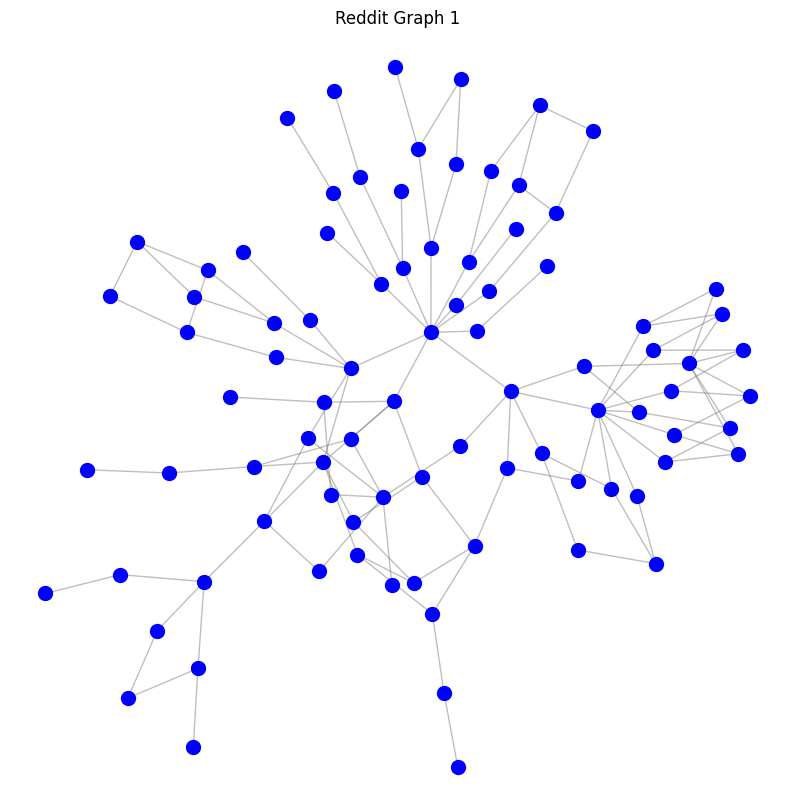

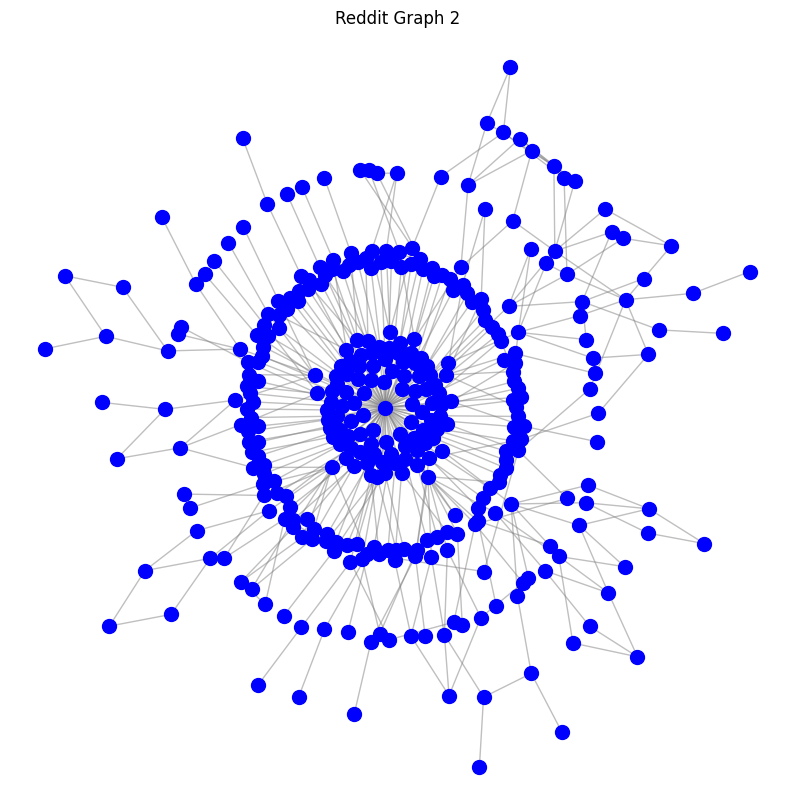

In [ ]:
import matplotlib.pyplot as plt

# Draw the graph using Kamada-Kawai layout
pos1 = nx.kamada_kawai_layout(graph1)
pos2 = nx.kamada_kawai_layout(graph2)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 10))
fig, ax2 = plt.subplots(figsize=(10, 10))

# Draw nodes
nx.draw_networkx_nodes(graph1, pos1, ax=ax1, node_size=100, node_color='blue')
nx.draw_networkx_nodes(graph2, pos2, ax=ax2, node_size=100, node_color='blue')

# Draw edges
nx.draw_networkx_edges(graph1, pos1, ax=ax1, edge_color='gray', alpha=0.5)
nx.draw_networkx_edges(graph2, pos2, ax=ax2, edge_color='gray', alpha=0.5)

# Draw labels
#nx.draw_networkx_labels(graph, pos, ax=ax, font_size=8)

# Set the title
ax1.set_title('Reddit Graph 1')
ax2.set_title('Reddit Graph 2')

# Remove the axis
ax1.axis('off')
ax2.axis('off')

# Show the plot
plt.show()

We will use the train_test_split() with the default parameters. It will extract 80% of the rows in the data as the training set, together with the corresponding labels for this data. The remaining 20% of the data, together with the remaining labels, is will be the test set.

The trained logistic regression model is used to make predictions on new data, specifically the number of interactions in a given Reddit post, using the predict method of the logistic regression model.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

# Manually assign labels based on node type
node_labels = {}
edge_labels = {}
for node in graph.nodes:
    node_type = graph.nodes[node].get('type')
    if node_type == 'comment':
        node_labels[node] = 'interaction'
    else:
        node_labels[node] = 'non_interaction'

#for edge in graph.edges:
#    edge_type = graph.edges[edge].get('type')
#    if edge_type == 'comment_to_comment' or edge_type == 'comment_to_submission':
#        edge_labels[edge] = 'interaction'
#    else:
#        edge_labels[edge] = 'non_interaction'

# Convert node labels to numerical values
label_encoder = LabelEncoder()
encoded_node_labels = label_encoder.fit_transform(list(node_labels.values()))

# Convert edge labels to numerical values
#encoded_edge_labels = label_encoder.transform(list(edge_labels.values()))

# Select a subset of node embeddings and edge labels
#num_samples = min(node_embeddings.shape[0], encoded_edge_labels.shape[0])
#node_embeddings_subset = node_embeddings[:num_samples]
#encoded_edge_labels_subset = encoded_edge_labels[:num_samples]

scaler = StandardScaler()
node_embeddings_scaled = scaler.fit_transform(node_embeddings)

# Split the data into training and testing sets
X_train_node, X_test_node, y_train, y_test = train_test_split(node_embeddings_scaled, encoded_node_labels, test_size=0.2, random_state=42)
#X_train_edge, X_test_edge, _, _ = train_test_split(encoded_edge_labels_subset, encoded_node_labels[:num_samples], test_size=0.2, random_state=42)

# Create and train the logistic regression model for nodes
logreg_node = LogisticRegression(max_iter=500)
logreg_node.fit(X_train_node, y_train)



# Create and train the logistic regression model for edges
#logreg_edge = LogisticRegression()
#logreg_edge.fit(X_train_edge.reshape(-1, 1), y_train)

# Gather Input Data
submission1 = reddit.submission(url=url1)
submission2 = reddit.submission(url=url2)

# Preprocess Input Data (Example: Text content)
text1 = submission1.title + ' ' + submission1.selftext
text2 = submission2.title + ' ' + submission2.selftext

# Pass Input Data to the Model for nodes
prediction_node1 = logreg_node.predict(node_embeddings1)
prediction_node2 = logreg_node.predict(node_embeddings2)

# Pass Input Data to the Model for edges
#prediction_edge1 = logreg_edge.predict(encoded_edge_labels_subset.reshape(-1, 1))
#prediction_edge2 = logreg_edge.predict(encoded_edge_labels_subset.reshape(-1, 1))

# Count the number of interactions for each post based on nodes and edges
num_interactions_node1 = len(prediction_node1[prediction_node1 == label_encoder.transform(['interaction'])])
#num_interactions_edge1 = len(prediction_edge1[prediction_edge1 == label_encoder.transform(['interaction'])])
num_interactions_node2 = len(prediction_node2[prediction_node2 == label_encoder.transform(['interaction'])])
#num_interactions_edge2 = len(prediction_edge2[prediction_edge2 == label_encoder.transform(['interaction'])])

In order to evaluate the accuracy of the logistic regression model on the test set, we use the score() method:

In [ ]:
# Print the predicted categories and the number of interactions for each post
print('Number of Interactions for Post 1:', num_interactions_node1)
print('Number of Interactions for Post 2:', num_interactions_node2)

# Calculate accuracy
accuracy = logreg_node.score(X_test_node, y_test)

# Calculate precision
precision = precision_score(y_test, logreg_node.predict(X_test_node))

# Calculate recall
recall = recall_score(y_test, logreg_node.predict(X_test_node))

# Calculate F1 score
f1 = f1_score(y_test, logreg_node.predict(X_test_node))

print("Accuracy: ", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Number of Interactions for Post 1: 49
Number of Interactions for Post 2: 144
Accuracy:  0.673469387755102
Precision: 0.58
Recall: 0.5178571428571429
F1 Score: 0.5471698113207547
